# Diminution de dimensions par LDA puis classification 
## Dataset MNIST

In [1]:
import pickle # sauvegarder le dataset

from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plot
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(threshold=np.inf) # option pour les print de valeurs

On gère un système de cache grâce à pickle pour ne pas refetch les données à chaque run du programme, puis on normalise

In [2]:
try:
    print("Searching for cached dataset...")
    mnist = pickle.load(open("mnist.pickle", "rb"))
    print("Cache found.")
except (OSError, IOError) as e: # ("ask for forgiveness" principle)
    print("No cache found. Downloading dataset...")
    mnist = fetch_openml('mnist_784', version=1, cache=True) # Choppe tout chez un serveur
    print("Saving dataset...")
    pickle.dump(mnist, open("mnist.pickle", "wb"))
    print("Saved.")
    
# On normalise les données d'entrainement entre 0 et 1

normaliseur = MinMaxScaler()
mnist.data = normaliseur.fit_transform(mnist.data)

Searching for cached dataset...
Cache found.


On print pour bien tout visualiser, et on s'occupe aussi de séparer les données d'entrainement des données de test, puis on fait la même chose en fonction des libellés.

In [3]:
# Nb images = 70000
# image = 28x28 = 784 pixels

print('dimensions des données : ', mnist.data.shape) # 70000 lignes et 784 colonnes (ou l'inverse)
print('nombre de pixels :', mnist.data[1].shape)
print('nombre de labels : ', mnist.target.shape)
# print(max(mnist.data[1]))
# print(mnist.data)

DEBUT_TESTS = 60001;
nb_train_voulu = 10000 #inférieur ou égal à 60k
nb_test_voulu = 100 #inférieur ou égal à 10k 

nb_test_ech = 10000;
train = np.transpose(mnist.data[:nb_train_voulu])
train_label = np.transpose(mnist.target[:nb_train_voulu])

test = np.transpose(mnist.data[DEBUT_TESTS:DEBUT_TESTS+nb_test_voulu])
test_label = np.transpose(mnist.target[DEBUT_TESTS:DEBUT_TESTS+nb_test_voulu])



print("Test labels : ", test_label.min(),"->", test_label.max())
print("Train labels : ", train_label.min(),"->", train_label.max())

print(train.shape)
print(test.shape)

dimensions des données :  (70000, 784)
nombre de pixels : (784,)
nombre de labels :  (70000,)
Test labels :  0 -> 9
Train labels :  0 -> 9
(784, 10000)
(784, 100)


Les étapes principales de cet algorithme vont commencer ici. Cette boucle for va établir les covariances interclasses et intraclasses, pour chacune d'entre-elles, après avoir rassemblé qualitativement les échantillons.
part_i correspond à un pourcentage de classe qui va jouer le rôle d'un coefficient d'importance.

On essaie différentes manières de calculer l'autocovariance : la méthode Si_i2 et Si_i3 fournissent les mêmes résultats et sont justes.

In [4]:
N = train.shape[1];
dimension = train.shape[0]

all_means = np.mean(train, axis=1)
Sw = np.zeros((dimension, dimension))
Sb = np.zeros((dimension, dimension))
Si = [] # covariance inter classe

for i in range(0, 10): # Le dernier exclu

    mask_vector_i = (train_label == str(i)) # = [0 1 0 0 1...], une matrice d'indices pour selectionner toutes les données d'un label particulier

    train_i = train[:,mask_vector_i] # data d'une classe

    n_i = train_i.shape[1]
    part_i = n_i / N
    mean_i = np.mean(train_i, axis=1)

    #Si_i1 = np.cov(train_i, train_i) # Autocovariance de chaque classe
    Si_i2 = np.cov(train_i) # Autocovariance de chaque classe
    #Si_i3 = (1/n_i) * (train_i - np.transpose(np.tile(mean_i, (n_i, 1)))).dot( np.transpose(train_i - np.transpose(np.tile(mean_i, (n_i, 1)))) ) # Autocovariance de chaque classe
    
    Si_i = Si_i2
       
    Sw += Si_i*part_i
 
    Sb += part_i * (mean_i - all_means).dot( np.transpose(mean_i - all_means) )# ici on pourrait passer par la cov si on a un tableau des moyennes de classes

    print('mask_vector_i.shape={}; train_i.shape={}; Si_i.shape={}; part_i={}; Sw.shape={}'.format(mask_vector_i.shape, train_i.shape, Si_i.shape, part_i, Sw.shape))

mask_vector_i.shape=(10000,); train_i.shape=(784, 1001); Si_i.shape=(784, 784); part_i=0.1001; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 1127); Si_i.shape=(784, 784); part_i=0.1127; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 991); Si_i.shape=(784, 784); part_i=0.0991; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 1032); Si_i.shape=(784, 784); part_i=0.1032; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 980); Si_i.shape=(784, 784); part_i=0.098; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 863); Si_i.shape=(784, 784); part_i=0.0863; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 1014); Si_i.shape=(784, 784); part_i=0.1014; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 1070); Si_i.shape=(784, 784); part_i=0.107; Sw.shape=(784, 784)
mask_vector_i.shape=(10000,); train_i.shape=(784, 944); Si_i.shape=(784, 784); part_i

Préparation de la réduction des dimensions, en prenant non pas la matrice de covariance de l'image de base, mais la matrice inverse (en l'occurence, la pseudo-inverse) ainsi que les éléments propres de cette dernière

In [5]:

M = np.linalg.pinv(Sw) * Sb; # Comme les matrices peuvent être singulières on utilise les pseudoinverses
U, S, V = np.linalg.svd(M)

print(M.shape)


(784, 784)


## Réduction des dimensions
Ici, on ne va garder que *p* composantes (sous-entendu valeurs propres) sur les 784 originales.

In [6]:
p = 784;
G = U[:, 0:p];
Y = np.transpose(G).dot(train);
Y_t = np.transpose(G).dot(test);
#accuracy = classifyNN(Y_t, Y, test_label, train_label)

## Fonction de classification
Ici, la classification est faite par *l'unique* plus proche voisin. Il faudrait la faire par *les* proches voisins, à savoir une classification K-NN, et, en fonction des K plus proche, déterminer la prédiction en fonction de la classe qui apparaît en majorité.

In [7]:
def classifyNN(Y_t, Y, test_label, train_label)
    train_size = Y.shape[1]
    test_size = Y_t.shape[1]
    counter = np.zeros(test_size)
    I_chapeau = np.ones(test_size)*(-1)

    print(test.shape)
    print(train.shape)

    print(Y_t.shape)
    print(Y.shape)

    for test_digit in range(0, test_size):


        test_mat = np.transpose(np.tile(Y_t[:, test_digit], (train_size, 1)))

        distance = sum(abs(test_mat - Y)**2);
        I = np.argmin(distance)
        I_chapeau

        if (train_label[I] == test_label[test_digit]):
            counter[test_digit] += 1

    accuracy = sum(counter) / test_size;
    print(accuracy)
    
classifyNN(Y_t, Y, test_label, train_label)

(784, 100)
(784, 10000)
(784, 100)
(784, 10000)
0.92


## Repassage au même nombre de dimensions 

In [8]:
print(U.shape)
print(G.shape)
zeros_pour_combler = np.zeros([U.shape[0], U.shape[1]-G.shape[1]])
print(zeros_pour_combler.shape)
U_chap = np.concatenate((G,zeros_pour_combler), axis=1)

#vérification
G_chap = U_chap[:, 0:p]
np.array_equal(G_chap, G) # = true

M_chap = np.dot(U_chap, np.dot(S, V))

(784, 784)
(784, 784)
(784, 0)


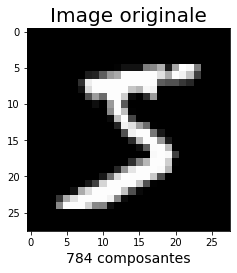

In [9]:
plot.figure(figsize=(8,4));

# Original Image
plot.subplot(1, 2, 1);
plot.imshow(mnist.data[0].reshape(28,28),
              cmap = plot.cm.gray, interpolation='nearest',
              clim=(0, 1));
plot.xlabel('784 composantes', fontsize = 14)
plot.title('Image originale', fontsize = 20);

plot.show();

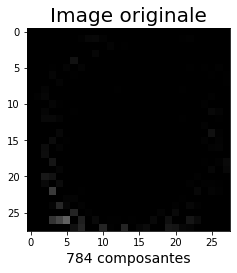

In [10]:
plot.figure(figsize=(8,4));

# Original Image
plot.subplot(1, 2, 1);
plot.imshow(U[:,test_size].reshape(28,28),
              cmap = plot.cm.gray, interpolation='nearest',
              clim=(0, 1));
plot.xlabel('784 composantes', fontsize = 14)
plot.title('Image originale', fontsize = 20);

plot.show();

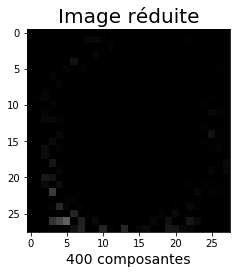

In [11]:
plot.figure(figsize=(8,4));

# Original Image
plot.subplot(1, 2, 1);
plot.imshow(U_chap[:,test_size].reshape(28,28),
              cmap = plot.cm.gray, interpolation='nearest',
              clim=(0, 1));
plot.xlabel('400 composantes', fontsize = 14)
plot.title('Image réduite', fontsize = 20);

plot.show();